**Problem**: 

I want to approximate the non-linear data space that makes up a PyPSA simulation. Specifically, I want to approximate a modified IEEE 13 bus topology with a uniform (grid) input. The approximation should be time sensitive.

**Objective**:

This notebook will only look at [support vector regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) (SVR) models. Per [1], the approximation should have a root mean sqaure error < 0.002 to ensure the approximation is not the largest source of error in the simulation. A standard linear regression will be shown for baseline comparison. Since the approximation is time sensitive, a search for the ball park number of samples required for reasonable scores is performed. Once the number of samples to produce reasonable results is found, a grid search can be ran to determine optimal training parameters.

**Hypothesis**: 

Previously, linear regression models outperformed artificial neural networks when tested on simple, small radial networks [2]. Since the modified IEEE 13 bus network contains two transformers whos behaviour can become non-linear if their power limit is exceeded (which is allowed in power flow [3]), I suspect there are two possible scenarios:

1. Transformer limit not exceeded: Linear regression outperforms RF model
2. Transformer limit exceeded: RF outperforms linear regressor because a RF model can capture non-linearity 

As for the number of samples required, historically 1e5-1e6 samples produces K-fold cross validation scores with low variance if the feature-label correlation is reasonable.

**Experimental Procedure**:

1. Determine the number of samples required to return reasonable scores with SVR K-fold cross validation. Reasonable scores is defined as:
  * R2 > 0.8
  * RMSE < 0.002
  * K-fold R2 variance one degree of magnitude less than R2
2. Using approximately that number of samples, run grid search to determine optimal parameters/hyperparameters

**Results**:

The model was unable to predict the first label. This is expected because the node represented by the label is a slack bus and therefore its voltage is always 1. The results for the other labels were averaged

* 1e4 samples (mean R2: 0.88, std dev: 0.002)
* 1e3 samples (mean R2: 0.87, std dev: 0.014)
* 1e2 samples (mean R2: 0.79, std dev: 0.076)
* 1e1 samples (mean R2: -15, std dev: 19)

If the slack bus is removed the results improve by roughly 9%

* 1e4 samples (mean R2: 0.96, std dev: 0.002)
* 1e3 samples (mean R2: 0.95, std dev: 0.009)
* 1e2 samples (mean R2: 0.87, std dev: 0.069)
* 1e1 samples (mean R2: -16, std dev: 20)

From 1e3 to 1e4 samples there is not a significant improvement in mean R2 (1%), but there is in the std dev (). From 1e2 to 1e3 it is more apparent (9%). Running a grid search with 1e3 samples produced the following results:

1. Mean R2: ? std dev: ?
2. Mean R2: ? std dev: ?
3. .
4. .

Tried training the model on 1e5 samples for over 5 hours. Cancelled.

**Discussion**:

One approach to reduce the cost of simulation-based research is to copy the underlying model and evaluate the approximation [1][4].

It takes roughly 7 hours to create 1e5 samples (by running PyPSA sim) on Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz


**Bibliography**

[1] https://github.com/mbardwell/masters

[2] Enhancing Power Flow Simulations Using Function Mapping. Michael Bardwell ; Petr Musilek. 2019 IEEE Canadian Conference on Electrical and Computer Engineering (CCECE)

[3] https://groups.google.com/forum/#!searchin/pypsa/mikey%7Csort:date/pypsa/FqfC_UR85k0/vBc7HYP_EQAJ

[4] ieee-13_timing-pfsim-vs-evaluating-models.ipynb


Table of Contents:
* Source data
* Analyse data
* Setup grid search

In [56]:
import pypsa
import time
import logging
import numpy as np
import warnings

warnings.filterwarnings('ignore')
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
%matplotlib inline

import copy
import csv
import sys
import time

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import pypsa
from n_dimensional_datasets import *
from plotter import *

from IPython.display import display # for better Pandas printing

In [57]:
def personalise_column_names(df, name):
        new_columns = []
        for column in df.columns:
            new_columns.append(name +  "-" + str(column))
        df.columns = new_columns
        return pd.DataFrame(df)

def collect_data(path_to_powerflow_data, data):
    '''
    Assumes folder tree has
    path_to_powerflow_data/
    -->datafiles
    -->results/
    '''
    data["loads"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "loads-p_set.csv"), "load")
    data["vmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vmags.csv"), "vmag")
    data["vangs"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vangs.csv"), "vang")
    data["qmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "qmags.csv"), "qmag")
    data["linemags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "linemags.csv"), "linemag")
    
import pandas as pd
import numpy as np
    
def set_uniform_sample_size(path_to_powerflow_data, data_to_change, n_samples, seed=None):
    '''
    Modifies common .csv files in PyPSA folders with uniformly sampled data 

    Parameters
    ----------
    path_to_powerflow_data: string
        ex: "/home/user/Documents/powerflow_data/"
    data_to_change: list of strings.
        ex: ["loads-p_set", "generators-p_max_pu", "snapshots"] 
    n_samples: int
    
    seed=None: int
    '''

    data = {}
    for datatype in data_to_change:
        data[datatype] = pd.read_csv(path_to_powerflow_data + datatype + ".csv")

    def increase_data(dataframe, n_samples, seed=None):
        addon = {}
        new_df_list = []
        for idx, column in enumerate(dataframe):
          
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:
                ## special cases
                if datatype == "generators-p_max_pu":
                    # add a ridiculous amount of generation so the is always enough power and sim doesn't fail
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=100, high=200, size=n_samples)
                elif datatype == "snapshots":
                    addon[column] = np.ones(n_samples)
                else:
                    addon[column] = np.random.RandomState(seed=seed).uniform(low=0, high=0.5, size=n_samples)
            elif dataframe[column].dtype == object:
                # assuming object is datetime column
                latest_datetime = pd.to_datetime(dataframe[column][0])
                addon[column] = []
                for sample in range(n_samples):
                    addon[column].append(latest_datetime + pd.Timedelta(hours=(1+sample)))
            else:
                raise TypeError("dataframe[column] type: {} should be object or float64/int64".format(
                    type(dataframe[column].dtype)))
        addon_dataframe = pd.DataFrame(addon)
        return dataframe.head(1).append(addon_dataframe)

    for datatype in data:
        data[datatype] = increase_data(data[datatype], n_samples-1, seed) # -1 is for original sample, which stays
        data[datatype].to_csv(path_to_powerflow_data + datatype + ".csv", index=False)
        print("Datatype {} stored".format(datatype))

def create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None):
    import os
    import shutil
    from pathlib import Path
    import pypsa

    if not os.path.isdir(path_to_powerflow_data):
        src = Path(path_to_powerflow_data).parents[0] / "ieee-13-with-load-gen/" # original modified IEEE model
        shutil.copytree(src, path_to_powerflow_data)

    set_uniform_sample_size(path_to_powerflow_data, data_to_change, sample_size, seed=None)

    network = pypsa.Network(import_name=path_to_powerflow_data)
    network.pf()

    save_path = path_to_powerflow_data + "results/"
    network.buses_t.v_mag_pu.to_csv(save_path + "vmags.csv")
    network.buses_t.v_ang.to_csv(save_path + "vangs.csv")
    network.buses_t.q.to_csv(save_path + "qmags.csv")
    network.lines_t.p0.to_csv(save_path + "linemags.csv")
    
def backup_samples(src, dest):
    '''
    thanks https://www.pythoncentral.io/how-to-recursively-copy-a-directory-folder-in-python/
    '''
    import os
    import errno
    import shutil
    
    try:
        if os.path.isdir(dest):
            shutil.rmtree(dest)
        shutil.copytree(src, dest)
        print("Backup to {} successful".format(dest))
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)

# Source Data

In [58]:
## USER INPUT
sample_size = 100000 # this is the max number of samples available

data_to_change = ["loads-p_set", "snapshots", "loads-q_set"]

path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = (path_to_powerflow_example +
                          "/ieee-13-with-load-gen-uniform-data-"
                          + str(sample_size) +
                          "-samples/")
path_to_powerflow_results = path_to_powerflow_data + "results/"

In [59]:
## Uncomment to generate load samples for modified IEEE-13 network
# if sample_size > 10000:
#     user = input("Are you sure [y/n]? This could erase hours worth of data")
#     if user == "y":
#         backup_samples(path_to_powerflow_results, path_to_powerflow_data + "results-backup/")
#         create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)
# else:
#     create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)

data = {"loads": [], "vmags": [], "vangs": [], "qmags": [], "linemags": []}
collect_data(path_to_powerflow_data, data)

# Analyse Data

In [60]:
features = data["loads"].drop("load-name", axis=1)
labels = data["vmags"].drop(["vmag-name", "vmag-Substation"], axis=1) #loc[:,["vmag-632", "vmag-671", "vmag-675"]]
features_and_labels = features.join(labels)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c9a760cd0>,
      dtype=object)

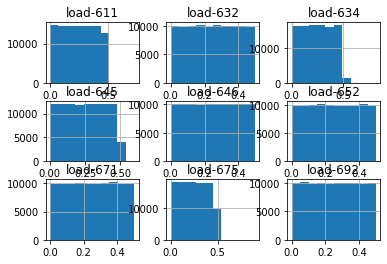

In [61]:
features.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c9a760ed0>,
      dtype=object)

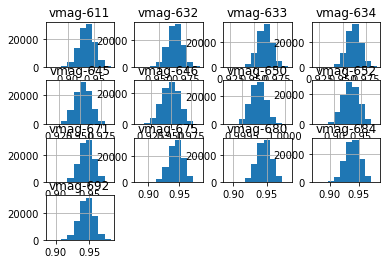

In [62]:
labels.hist()

In [63]:
corr_matrix = labels.join(features).corr()

# only loads for columns
cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
reduced_corr_matrix = corr_matrix[cols]
reduced_corr_matrix["row average"] = pd.Series(reduced_corr_matrix.mean(axis=1))
# only voltages for rows
rows = reduced_corr_matrix.index[reduced_corr_matrix.index.str.contains("load")]
reduced_corr_matrix.drop(rows, inplace=True)
reduced_corr_matrix = reduced_corr_matrix.append(pd.Series(reduced_corr_matrix.mean(), name="column average"))

display(reduced_corr_matrix)

,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
vmag-650,-0.008439,0.001458,-0.002953,-0.000081,-0.001955,-0.007134,-0.001353,-0.004306,-0.001971,-0.002970
vmag-646,-0.196512,-0.200144,-0.487273,-0.671172,-0.211606,-0.204674,-0.199273,-0.208235,-0.211118,-0.287779
vmag-645,-0.219407,-0.223990,-0.546822,-0.558979,-0.235927,-0.229190,-0.223332,-0.233060,-0.236599,-0.300812
vmag-632,-0.316812,-0.320804,-0.319882,-0.333944,-0.339195,-0.329811,-0.324215,-0.334387,-0.339914,-0.328774
vmag-633,-0.286406,-0.512513,-0.289868,-0.302645,-0.307178,-0.298881,-0.292050,-0.303695,-0.307554,-0.322310
vmag-634,-0.286326,-0.512387,-0.289801,-0.302548,-0.307111,-0.298800,-0.291940,-0.303616,-0.307463,-0.322221
vmag-611,-0.157880,-0.158084,-0.155850,-0.168281,-0.463138,-0.316864,-0.313902,-0.320260,-0.600170,-0.294936
vmag-684,-0.170285,-0.171447,-0.168631,-0.182151,-0.502244,-0.343257,-0.340429,-0.346904,-0.501052,-0.302933
vmag-671,-0.196724,-0.199334,-0.196651,-0.210183,-0.410146,-0.399117,-0.395772,-0.403272,-0.410221,-0.313491
vmag-692,-0.196689,-0.199299,-0.196616,-0.210148,-0.410075,-0.399049,-0.395916,-0.403413,-0.410151,-0.313484


# Setup Models

In [64]:
import csv
import datetime

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from scoring import rmse

In [65]:
def set_data_size(n_samples, n_training_samples):
    X_train, X_val, y_train, y_val, test_idx, train_idx = train_test_split(features,
                                                                           labels,
                                                                           range(features.shape[0]),
                                                                           train_size=n_training_samples,
                                                                           test_size=n_samples-n_training_samples,
                                                                           random_state=None)
    X_train = X_train.values
    y_train = y_train.values
    X_val = X_val.values
    y_val = y_val.values

    return X_train, y_train, X_val, y_val

# Determine number of samples to get reasonable scores

In [14]:
# setup model parameters/hyperparameters

'''
dnn hyperparameters are chosen from sandbox testing. On average the model attempts to converge 
(with other parameters it sometimes gives up early).
'''
svr = SVR(gamma='scale', C=1.0, epsilon=0.0002, kernel='rbf')

linear = LinearRegression()

In [ ]:
svr_xval_scores = []
linear_xval_scores = []
for i, n_samples in enumerate([100, 1000, 10000, 100000]):
    current_iteration = i

    n_training_samples = int(n_samples*(80/100))
    X_train, y_train, X_val, y_val = set_data_size(n_samples, n_training_samples)

    print("\n\nRun: ", current_iteration)
    print("n_training_samples: ", n_training_samples)
    print("n_validation_samples: ", n_samples-n_training_samples)
    print("n_features: ", X_train.shape[1])
    print("n_labels: ", y_train.shape[1])

    ## svr - can only predict one label at a time
    print("\n\nSVR\n\n")
    
    time_start = time.time()
    svr_models = []
    for label in range(y_train.shape[1]):
        svr_y_train = y_train.T[label].T
        svr_xval_scores = pd.DataFrame(cross_validate(svr, 
                                                      X_train, 
                                                      svr_y_train, 
                                                      cv=5, 
                                                      n_jobs=-1, 
                                                      scoring=make_scorer(r2_score)))
        svr_xval_scores.columns = [col + "_label_" + str(label) for col in svr_xval_scores.columns]
        if label == 0:
            svr_results = svr_xval_scores
        else:
            svr_results = svr_results.join(svr_xval_scores)
        
        svr_models.append(svr.fit(X_train, svr_y_train))

    time_svr = time.time()
    print("cross validation training time {:.5}".format(time_svr-time_start))
    print("cross validation training scores: ")
    display(svr_results)

    print("non-cross validation model scores for reference:")
    for label in range(y_train.shape[1]):
        print("label: ", label)
        print("training score: ", r2_score(y_train.T[label].T, svr.predict(X_train)))
        print("validation score: ", r2_score(y_val.T[label].T, svr.predict(X_val)))
        print("rmse: ", rmse(y_val.T[label].T, svr.predict(X_val)))

    ## linear regression
    print("\n\nLINEAR REGRESSION\n\n")
    time_start = time.time()
    linear_xval_scores.append(cross_validate(linear,
                                             X_train,
                                             y_train,
                                             cv=5,
                                             n_jobs=-1,
                                             scoring=make_scorer(r2_score)))

    time_linear = time.time()
    print("cross validation training time {:.5}".format(time_linear-time_start))
    print("cross validation training scores: ")
    linear_results = pd.DataFrame(linear_xval_scores[current_iteration])
    linear_results.columns = ["linear_"+col for col in linear_results.columns]
    display(linear_results)

    linear.fit(X_train, y_train)
    print("non-cross validation model scores for reference:")
    print("training score: ", r2_score(y_train, linear.predict(X_train)))
    print("validation score: ", r2_score(y_val, linear.predict(X_val)))
    print("rmse: ", rmse(linear.predict(X_val), y_val))

    ## model statistics
    datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
    results_to_save = linear_results.join(svr_results).round(3)
    results_to_save.to_csv(path_to_powerflow_data + 
                           "/results/approximating_with_svr_results-{}_samples-{}.csv".format(n_samples, 
                                                                                             datetimestamp))



Run:  0
n_training_samples:  80
n_validation_samples:  20
n_features:  9
n_labels:  13


SVR


cross validation training time 0.33906
cross validation training scores: 


,fit_time_label_0,score_time_label_0,test_score_label_0,fit_time_label_1,score_time_label_1,test_score_label_1,fit_time_label_2,score_time_label_2,test_score_label_2,fit_time_label_3,...,test_score_label_9,fit_time_label_10,score_time_label_10,test_score_label_10,fit_time_label_11,score_time_label_11,test_score_label_11,fit_time_label_12,score_time_label_12,test_score_label_12
0,0.001367,0.000628,-0.404138,0.000908,0.000521,0.881090,0.000912,0.000601,0.902811,0.000664,...,0.767919,0.000629,0.000437,0.766022,0.000663,0.000442,0.771251,0.000659,0.000434,0.767909
1,0.030785,0.000973,-0.138660,0.000912,0.000502,0.940861,0.000780,0.000466,0.941230,0.000708,...,0.937353,0.000651,0.000432,0.936000,0.000741,0.000477,0.937015,0.000650,0.000463,0.937355
2,0.001328,0.000656,-0.061851,0.000711,0.000480,0.918889,0.000669,0.000434,0.931277,0.000601,...,0.925586,0.000611,0.000425,0.920585,0.000711,0.000489,0.918964,0.000597,0.000409,0.925600
3,0.001519,0.000801,-0.172559,0.000712,0.000491,0.929882,0.000565,0.000415,0.926467,0.000574,...,0.895069,0.000569,0.000430,0.894911,0.000623,0.000433,0.856707,0.023688,0.000560,0.895062
4,0.000540,0.000441,-0.006380,0.000839,0.000594,0.770056,0.000559,0.000442,0.776781,0.000539,...,0.802709,0.000594,0.000412,0.794008,0.000604,0.000433,0.847214,0.000777,0.000524,0.802676


non-cross validation model scores for reference:
label:  0
training score:  -398891.1983399248
validation score:  -368276.3536812776
rmse:  0.05546627698395137
label:  1
training score:  0.5736464958564393
validation score:  0.21199693282003174
rmse:  0.007551526085124966
label:  2
training score:  0.2948369491754753
validation score:  -0.5077203291707015
rmse:  0.009020238977857383
label:  3
training score:  -7.859667987796241
validation score:  -14.365136360019951
rmse:  0.01892231492999851
label:  4
training score:  -4.298954723704377
validation score:  -6.0733882511091
rmse:  0.015525147125494984
label:  5
training score:  -4.253317115079584
validation score:  -6.023302260185082
rmse:  0.015468948687056944
label:  6
training score:  0.25464384942409357
validation score:  -0.7923164901690274
rmse:  0.014022642096046896
label:  7
training score:  0.6054600142662074
validation score:  -0.13975106261606962
rmse:  0.01019671004289791
label:  8
training score:  0.9984774240967816
validat

,linear_fit_time,linear_score_time,linear_test_score
0,0.001755,0.000474,0.860111
1,0.001018,0.000420,0.906727
2,0.000563,0.000378,0.895310
3,0.000551,0.000375,0.882817
4,0.000560,0.000400,0.845123


non-cross validation model scores for reference:
training score:  0.9137280358009785
validation score:  0.8674069049458768
rmse:  0.001646198179553289


Run:  1
n_training_samples:  800
n_validation_samples:  200
n_features:  9
n_labels:  13


SVR


cross validation training time 6.8781
cross validation training scores: 


,fit_time_label_0,score_time_label_0,test_score_label_0,fit_time_label_1,score_time_label_1,test_score_label_1,fit_time_label_2,score_time_label_2,test_score_label_2,fit_time_label_3,...,test_score_label_9,fit_time_label_10,score_time_label_10,test_score_label_10,fit_time_label_11,score_time_label_11,test_score_label_11,fit_time_label_12,score_time_label_12,test_score_label_12
0,0.001030,0.000656,-0.041337,0.224496,0.004013,0.961345,0.174110,0.004127,0.958765,0.098003,...,0.956391,0.187610,0.004374,0.957396,0.230689,0.016093,0.955812,0.167104,0.012935,0.956311
1,0.000714,0.000559,-0.161251,0.120450,0.009422,0.960614,0.105753,0.003833,0.959537,0.180407,...,0.961784,0.237476,0.004564,0.962050,0.166790,0.004499,0.962031,0.201628,0.005284,0.962187
2,0.001593,0.000464,-0.023947,0.147391,0.039989,0.942821,0.127923,0.028219,0.941702,0.140484,...,0.944901,0.296333,0.029478,0.947705,0.225302,0.049461,0.947311,0.153859,0.004582,0.945782
3,0.000955,0.000689,-0.152011,0.223858,0.003908,0.962616,0.166143,0.017381,0.962554,0.121875,...,0.963718,0.232661,0.013601,0.964819,0.134406,0.044381,0.961410,0.157701,0.005725,0.963396
4,0.000805,0.000441,-0.011250,0.151633,0.004563,0.950752,0.127154,0.013142,0.948683,0.064667,...,0.945887,0.138421,0.008377,0.948549,0.176385,0.005634,0.944803,0.124232,0.024353,0.946977


non-cross validation model scores for reference:
label:  0
training score:  -404598.9390780738
validation score:  -414598.1517789576
rmse:  0.05410832875613987
label:  1
training score:  0.41665275733875473
validation score:  0.34057648821372266
rmse:  0.008793927420683278
label:  2
training score:  0.03057768184307008
validation score:  -0.06533633217975354
rmse:  0.009897571728430197
label:  3
training score:  -7.540752585911884
validation score:  -7.862868910864115
rmse:  0.019444544043972015
label:  4
training score:  -4.070310623558734
validation score:  -4.326539462361496
rmse:  0.016547564785426013
label:  5
training score:  -4.039441078929949
validation score:  -4.290228174341879
rmse:  0.01649477922679165
label:  6
training score:  0.3445295159026497
validation score:  0.27008820626569174
rmse:  0.011205536007669513
label:  7
training score:  0.6606542480072028
validation score:  0.5995833597282114
rmse:  0.00762957691840547
label:  8
training score:  0.9987645986340599
valida

,linear_fit_time,linear_score_time,linear_test_score
0,0.002637,0.000549,0.906108
1,0.002035,0.000550,0.903111
2,0.001780,0.000544,0.904385
3,0.001600,0.000489,0.903627
4,0.001248,0.000495,0.899888


non-cross validation model scores for reference:
training score:  0.9077665845281383
validation score:  0.9048806366132508
rmse:  0.0013710857936568197


Run:  2
n_training_samples:  8000
n_validation_samples:  2000
n_features:  9
n_labels:  13


SVR




# Importing results for calculating mean/std

This is different than the RF/DNN notebooks because there are more numbers to crunch

In [47]:
def mean_and_std(results_dataframe, label_min):
    scores = imported_results.loc[:,["test_score_label_" + str(i) for i in range(label_min,13)]]
    means = scores.mean()
    stds = scores.std()
    the_mean = np.mean(means)
    the_std = np.mean(stds)
    print("mean: {:.5} std: {:.5} for labels from {} to 12".format(the_mean, the_std, label_min))


imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-10000_samples-2019-09-12-00-21.csv")
imported_results_hold1 = imported_results
mean_and_std(imported_results, 0)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-1000_samples-2019-09-11-23-22.csv")
imported_results_hold2 = imported_results
mean_and_std(imported_results, 0)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-100_samples-2019-09-11-23-22.csv")
mean_and_std(imported_results, 0)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-10_samples-2019-09-11-23-20.csv")
mean_and_std(imported_results, 0)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-10000_samples-2019-09-12-00-21.csv")
mean_and_std(imported_results, 1)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-1000_samples-2019-09-11-23-22.csv")
mean_and_std(imported_results, 1)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-100_samples-2019-09-11-23-22.csv")
mean_and_std(imported_results, 1)

imported_results = pd.read_csv(path_to_powerflow_data + "results/" + 
            "approximating_with_svr_results-10_samples-2019-09-11-23-20.csv")
mean_and_std(imported_results, 1)

display(imported_results_hold1)
display(imported_results_hold2)

mean: 0.88242 std: 0.0019049 for labels from 0 to 12
mean: 0.87425 std: 0.013803 for labels from 0 to 12
mean: 0.7944 std: 0.075523 for labels from 0 to 12
mean: -14.923 std: 18.887 for labels from 0 to 12
mean: 0.95605 std: 0.0019939 for labels from 1 to 12
mean: 0.95358 std: 0.0088948 for labels from 1 to 12
mean: 0.87367 std: 0.069082 for labels from 1 to 12
mean: -15.676 std: 19.772 for labels from 1 to 12


,Unnamed: 0,linear_fit_time,linear_score_time,linear_test_score,fit_time_label_0,score_time_label_0,test_score_label_0,fit_time_label_1,score_time_label_1,test_score_label_1,...,test_score_label_9,fit_time_label_10,score_time_label_10,test_score_label_10,fit_time_label_11,score_time_label_11,test_score_label_11,fit_time_label_12,score_time_label_12,test_score_label_12
0,0,0.010,0.001,0.905,0.004,0.001,-0.000,162.387,1.073,0.961,...,0.960,68.145,0.441,0.961,67.372,0.433,0.964,70.088,0.460,0.959
1,1,0.010,0.001,0.906,0.003,0.001,-0.001,159.017,0.999,0.956,...,0.957,68.869,0.444,0.959,65.471,0.436,0.963,67.659,0.419,0.957
2,2,0.016,0.002,0.906,0.003,0.001,-0.002,163.874,0.829,0.962,...,0.956,68.181,0.431,0.957,67.798,0.445,0.961,69.363,0.530,0.956
3,3,0.009,0.001,0.905,0.003,0.001,-0.001,163.062,0.941,0.957,...,0.956,68.627,0.449,0.957,67.603,0.449,0.961,68.765,0.535,0.956
4,4,0.006,0.001,0.905,0.002,0.001,-0.002,96.826,0.651,0.959,...,0.958,67.617,0.483,0.959,67.553,0.454,0.963,68.641,0.433,0.958


,Unnamed: 0,linear_fit_time,linear_score_time,linear_test_score,fit_time_label_0,score_time_label_0,test_score_label_0,fit_time_label_1,score_time_label_1,test_score_label_1,...,test_score_label_9,fit_time_label_10,score_time_label_10,test_score_label_10,fit_time_label_11,score_time_label_11,test_score_label_11,fit_time_label_12,score_time_label_12,test_score_label_12
0,0,0.003,0.001,0.906,0.001,0.001,-0.041,0.224,0.004,0.961,...,0.956,0.188,0.004,0.957,0.231,0.016,0.956,0.167,0.013,0.956
1,1,0.002,0.001,0.903,0.001,0.001,-0.161,0.120,0.009,0.961,...,0.962,0.237,0.005,0.962,0.167,0.004,0.962,0.202,0.005,0.962
2,2,0.002,0.001,0.904,0.002,0.000,-0.024,0.147,0.040,0.943,...,0.945,0.296,0.029,0.948,0.225,0.049,0.947,0.154,0.005,0.946
3,3,0.002,0.000,0.904,0.001,0.001,-0.152,0.224,0.004,0.963,...,0.964,0.233,0.014,0.965,0.134,0.044,0.961,0.158,0.006,0.963
4,4,0.001,0.000,0.900,0.001,0.000,-0.011,0.152,0.005,0.951,...,0.946,0.138,0.008,0.949,0.176,0.006,0.945,0.124,0.024,0.947


# Search

In [76]:
from sklearn.model_selection import RandomizedSearchCV
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 600)

In [67]:
n_samples = 10000
if n_samples < 10000:
    raise ValueError("So you don't accidentally run this on 100 samples again")
n_training_samples = int(n_samples*(80/100))
X_train, y_train, X_val, y_val = set_data_size(n_samples, n_training_samples)

In [ ]:
svr = SVR()
params = {"gamma": ["auto", "scale"], 
          "C": [i*5/1000 for i in range(0,1000)], # min: 0, max: 5
          "epsilon": [i*2/1000000 for i in range(1,1000)], # min: 2e-6, max: 2e-3
          "kernel": ["rbf", "poly", "sigmoid", "linear"],
          "tol": [1e-3] # min: 1e-6, max: 1e-3
         }


for label in range(1, y_train.shape[1]):
    svr_y_train = y_train.T[label].T

    grid = RandomizedSearchCV(svr, params, cv=5, n_iter=30, n_jobs=-1, refit=False,
                      scoring={"r2": make_scorer(r2_score), "rmse": make_scorer(rmse)}, iid=False, verbose=10)

    grid.fit(X_train, svr_y_train)

    print("\n\nSVR\n\n")
    grid_results = pd.DataFrame(grid.cv_results_)
    display(grid_results.sort_values(by=["rank_test_r2"]))
    datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
    filepath = (path_to_powerflow_data + 
                "/results/approximating_with_svr_grid_results-{}_samples-{}_label-{}.csv".format(
                    n_samples, datetimestamp, label))
    print("Saving to ", filepath)
    grid_results.to_csv(filepath)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 10.6min


In [77]:
# for reading values if you closed the notebook
# filepath = (path_to_powerflow_data +
#            "/results/approximating_with_svr_grid_results-10000_samples-2019-09-12-21-08_label-12.csv")
imported_results = pd.read_csv(filepath)
display(imported_results.sort_values(by=["rank_test_r2"]))

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_kernel,param_gamma,param_epsilon,param_C,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
6,6,0.004027,0.003173,0.001795,0.000185,0.00641,rbf,auto,0.0282,3.230,"{'tol': 0.00641, 'kernel': 'rbf', 'gamma': 'au...",0.300632,0.321616,0.320192,0.323132,0.325418,0.318198,0.008952,1,0.009030,0.008841,0.008676,0.008804,0.008927,0.008856,0.000119,10
4,4,0.002008,0.000317,0.008344,0.008668,0.00824,poly,scale,0.0242,4.630,"{'tol': 0.00824, 'kernel': 'poly', 'gamma': 's...",0.092631,0.283887,0.244285,0.276795,0.296674,0.238855,0.075128,2,0.010286,0.009083,0.009148,0.009100,0.009115,0.009346,0.000470,9
1,1,0.001963,0.000263,0.001557,0.000138,0.00140,poly,scale,0.0940,0.065,"{'tol': 0.0014, 'kernel': 'poly', 'gamma': 'sc...",-0.000622,-0.016433,-0.009225,-0.014644,-0.019426,-0.012070,0.006617,3,0.010801,0.010821,0.010571,0.010779,0.010974,0.010789,0.000129,8
0,0,0.003453,0.001175,0.003422,0.003401,0.00255,sigmoid,scale,0.1110,3.310,"{'tol': 0.00255, 'kernel': 'sigmoid', 'gamma':...",-0.000622,-0.016433,-0.009225,-0.014644,-0.019426,-0.012070,0.006617,4,0.010801,0.010821,0.010571,0.010779,0.010974,0.010789,0.000129,2
2,2,0.002120,0.000141,0.008455,0.013998,0.00009,sigmoid,scale,0.0562,3.900,"{'tol': 9e-05, 'kernel': 'sigmoid', 'gamma': '...",-0.000622,-0.016433,-0.009225,-0.014644,-0.019426,-0.012070,0.006617,4,0.010801,0.010821,0.010571,0.010779,0.010974,0.010789,0.000129,2
7,7,0.002677,0.001642,0.011723,0.015116,0.00645,rbf,scale,0.0504,3.740,"{'tol': 0.00645, 'kernel': 'rbf', 'gamma': 'sc...",-0.000622,-0.016433,-0.009225,-0.014644,-0.019426,-0.012070,0.006617,4,0.010801,0.010821,0.010571,0.010779,0.010974,0.010789,0.000129,2
8,8,0.004473,0.004843,0.001540,0.000016,0.00577,sigmoid,scale,0.1376,0.570,"{'tol': 0.00577, 'kernel': 'sigmoid', 'gamma':...",-0.000622,-0.016433,-0.009225,-0.014644,-0.019426,-0.012070,0.006617,4,0.010801,0.010821,0.010571,0.010779,0.010974,0.010789,0.000129,2
9,9,0.005063,0.006830,0.004357,0.004945,0.00539,poly,auto,0.0604,3.990,"{'tol': 0.00539, 'kernel': 'poly', 'gamma': 'a...",-0.000622,-0.016433,-0.009225,-0.014644,-0.019426,-0.012070,0.006617,4,0.010801,0.010821,0.010571,0.010779,0.010974,0.010789,0.000129,2
5,5,0.002014,0.000119,0.001459,0.000043,0.00650,sigmoid,scale,0.0926,0.080,"{'tol': 0.0065, 'kernel': 'sigmoid', 'gamma': ...",-0.000622,-0.016433,-0.009225,-0.014644,-0.019426,-0.012070,0.006617,9,0.010801,0.010821,0.010571,0.010779,0.010974,0.010789,0.000129,2
3,3,0.001501,0.000087,0.001492,0.000031,0.00682,poly,auto,0.1702,3.685,"{'tol': 0.00682, 'kernel': 'poly', 'gamma': 'a...",-0.000622,-0.016433,-0.009225,-0.014644,-0.019426,-0.012070,0.006617,10,0.010801,0.010821,0.010571,0.010779,0.010974,0.010789,0.000129,1
